Importing relevant packages and modules

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

In [2]:
import sys
from pathlib import Path
import torch
import numpy as np
import tqdm

# Plotting
import matplotlib
from matplotlib import pyplot as plt
plt.style.use('bioAI.mplstyle')

'''
CUSTOM PACKAGES
'''
# avoid adding multiple relave paths to sys.path
sys.path.append("../src") if "../src" not in sys.path else None

from Models import SorscherRNN
from Experiment import Experiment
from datahandling import Dataset, MESampler
from plotting_functions import *
from synthetic_grid_cells import *
from methods import *
from stats import *

import utils

In [3]:
#base_path = Path("/storA/GridCells/")
base_path = "/mnt/WD12TB-HDD"
experiment = Experiment(name="gg-3ME", base_path=base_path)
experiment.setup()
paths = experiment.paths
boxsize = experiment.environments[0].boxsize

Experiment <gg-3ME> already EXISTS. Loading experiment settings!
Loading experiment details
This experiment has ALREADY been setup - SKIPPING.


In [4]:
module_indices = np.load(f"{experiment.paths['experiment']}/module_indices_all_clusters.npz")
clusters = [module_indices[f] for f in module_indices.files]

torus_cells = list(clusters[2]) + list(clusters[12]) + list(clusters[15])
torus_cells.sort()
clustered_grid_cells = clusters[1]
border_cells = list(clusters[3]) + list(clusters[8])
border_cells.sort()
place_cells = clusters[10]
# include the rest of the cells in the unsorted cells (18 clusters total)
unsorted_cells = list(clusters[0]) + list(clusters[4]) + list(clusters[5]) + list(clusters[6]) + list(clusters[7]) + \
    list(clusters[9]) + list(clusters[11]) + list(clusters[13]) + list(clusters[14]) + list(clusters[16]) + list(clusters[17])
unsorted_cells.sort()
print(f"{len(torus_cells)=}, {len(clustered_grid_cells)=}, {len(border_cells)=}, {len(place_cells)=}, {len(unsorted_cells)=}")
clusters = [torus_cells, clustered_grid_cells, border_cells, place_cells, unsorted_cells]
cluster_labels = ["torus", "clustered grid", "border", "place", "unsorted"]

len(torus_cells)=604, len(clustered_grid_cells)=85, len(border_cells)=167, len(place_cells)=103, len(unsorted_cells)=2172


In [5]:
import copy
ratemaps = []
for env_i in range(3):
    with open(paths['ratemaps'] / (f'env_{env_i}/' + filenames(paths['ratemaps'] / f'env_{env_i}')[-1]), 'rb') as f:
        tmp_ratemaps = pickle.load(f)
        # fix nans
        tmp_ratemaps = np.array([fill_nan(ratemap, method='nearest') for ratemap in tmp_ratemaps])
        ratemaps.append(tmp_ratemaps)
ratemaps = np.stack(ratemaps)
all_ratemaps = copy.deepcopy(ratemaps)
ratemaps = ratemaps[:, torus_cells]
ncells = ratemaps.shape[1]

In [6]:

# split torus cluster into three band cell clusters
band_classes = cluster_ratemaps(ratemaps[0]) # assume ratemaps are torus ratemaps here
band_cells = [np.array(torus_cells)[band_classes == i] for i in range(3)]

100%|██████████| 604/604 [00:28<00:00, 21.12it/s]


In [7]:
def load_model(experiment, random_model=False):
    # load weights
    checkpoint_filenames = filenames(experiment.paths['checkpoints'])
    # load model latest (wrt. #epochs trained)
    print(f"Loading model at epoch = {checkpoint_filenames[-1]}", experiment.paths['checkpoints'] / checkpoint_filenames[-1])
    checkpoint = torch.load(experiment.paths['checkpoints'] / checkpoint_filenames[-1])
    # instantiate trained model this time
    model = SorscherRNN(experiment.pc_ensembles, Ng=experiment.params['Ng'], Np=experiment.params['Np'])
    if not random_model:
        model.load_state_dict(checkpoint['model_state_dict'])
    return model

model = load_model(experiment)
random_model = load_model(experiment, random_model=True)

Loading model at epoch = 02999 /mnt/WD12TB-HDD/data/emergent-grid-cells/gg-3ME/checkpoints/02999
Loading model at epoch = 02999 /mnt/WD12TB-HDD/data/emergent-grid-cells/gg-3ME/checkpoints/02999


In [8]:
# overload dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(
        self, agents, pc_ensembles, num_samples, seq_len=20, basis_vector=None, **kwargs
    ):
        self.agents = agents
        self.pc_ensembles = pc_ensembles
        self.seq_len = seq_len
        self.num_samples = num_samples
        self.basis_vector = basis_vector if basis_vector is not None else np.array([1, 0])
        if np.linalg.norm(self.basis_vector) != 1:
            # make unit vector
            self.basis_vector = self.basis_vector / np.linalg.norm(self.basis_vector)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        agent = self.agents[index]
        place_cells = self.pc_ensembles[index]
        agent.reset()
        for _ in range(self.seq_len):
            agent.step()

        # get velocities and project onto basis vector
        velocities = agent.velocities 
        velocities = velocities @ self.basis_vector[:, None] * self.basis_vector[None, :]
        agent._positions = agent.positions[-1:] # only keep last position
        # set velocities such that positions gets calculated correctly
        agent._velocities = velocities

        velocities = torch.tensor(velocities[1:], dtype=torch.float32)
        positions = torch.tensor(agent.positions, dtype=torch.float32)
        pc_positions = place_cells.softmax_response(positions)
        init_pc_positions, labels = pc_positions[0], pc_positions[1:]
        
        return [[velocities, init_pc_positions], labels, positions, index]

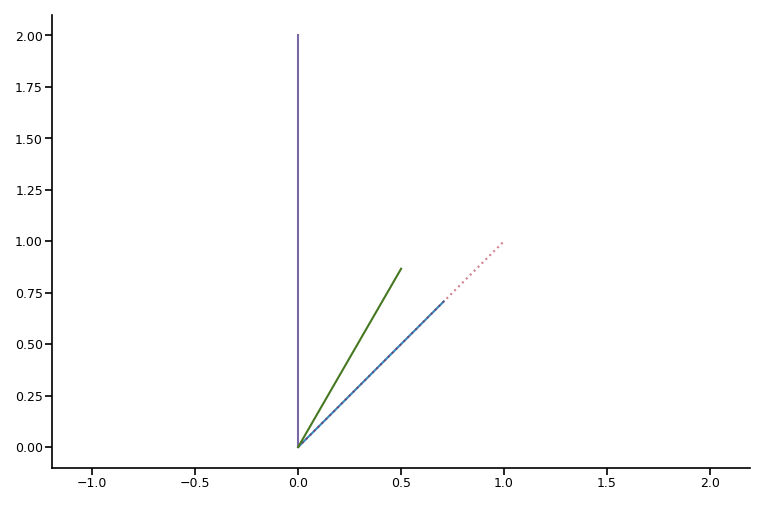

In [9]:
e1 = np.ones(2)/np.linalg.norm(np.ones(2))
# plot e1 as a vector using plt.plot, and origin at zero
plt.plot([0, e1[0]], [0, e1[1]])
v = np.array([0,2])
plt.plot([0, v[0]], [0, v[1]])
plt.axis('equal')
e1v = np.dot(e1, v) * e1
plt.plot([0, e1v[0]], [0, e1v[1]], ':', alpha = 0.5)
u = rotation_matrix(60) @ np.array([1,0])
plt.plot([0, u[0]], [0, u[1]])

In [10]:
# detach experiment specifics
params = experiment.params
environments = experiment.environments
agents = experiment.agents
pc_ensembles = experiment.pc_ensembles
paths = experiment.paths

num_workers = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{device=}")

# Initialise data loading
seq_len = 20
basis_vector = np.array([1, 0])
basis_vector = rotation_matrix(120) @ basis_vector # rotate basis vector
num_samples = params['nsteps'] * params['batch_size'] # * params['nepochs']
dataset = Dataset(agents = agents, pc_ensembles = pc_ensembles, num_samples = num_samples, seq_len=seq_len, basis_vector=basis_vector)#, **params)
datasampler = eval(params['sampler'])(num_environments = len(environments), num_samples = num_samples, \
                                      num_epochs = params['nepochs'])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=params['batch_size'], sampler = datasampler, num_workers=num_workers)

device=device(type='cuda')


In [11]:
for batch in dataloader:
    print(batch[0][0].shape, batch[0][1].shape, batch[1].shape, batch[2].shape)
    break

torch.Size([200, 20, 2]) torch.Size([200, 512]) torch.Size([200, 20, 512]) torch.Size([200, 21, 2])


In [12]:
pred = model(batch[0], log_softmax=True)
model.position_error(pred[:,slice(19,20)], batch[2][:,slice(19,20+1)], np.array(batch[-1]), model.place_cell_ensembles).item()

0.1944970190525055

/tmp/ipykernel_529218/940572474.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(batch[0][0][0,:,0].numpy(), batch[0][0][0,:,1].numpy(), cmap='viridis')


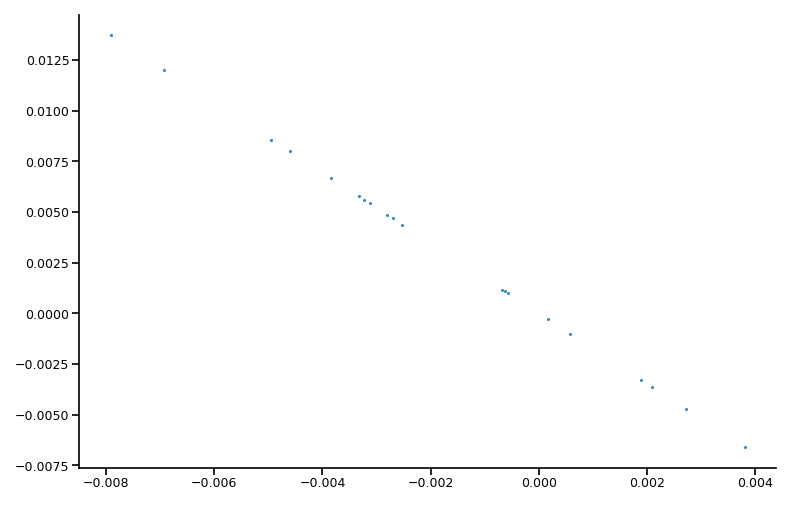

In [13]:
plt.scatter(batch[0][0][0,:,0].numpy(), batch[0][0][0,:,1].numpy(), cmap='viridis')

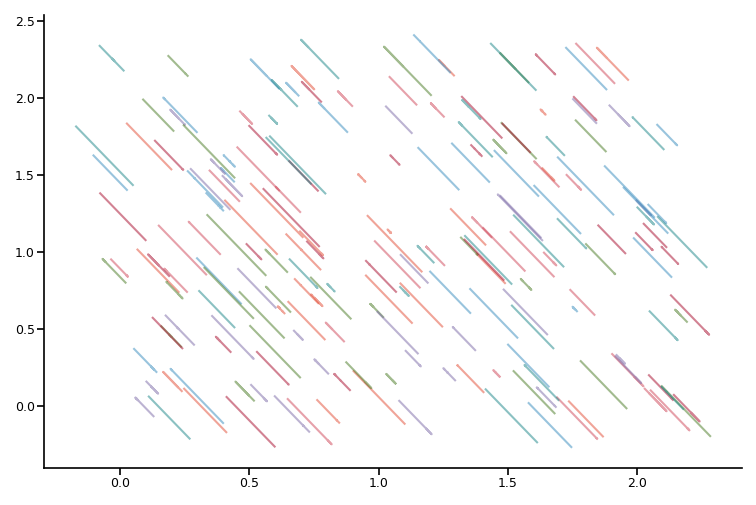

In [14]:

plt.plot(batch[2].numpy()[...,0].T, batch[2].numpy()[...,1].T, alpha=0.5)

In [15]:
from tqdm import tqdm

def prune_model(model, random_model, dataloader, B1, B2, B3, trajectory_slice=slice(19,20), nsamples=30, ncells2prune=100):
    # full, untrained, random and band cells 
    errors = np.zeros((nsamples, 1+1+1+3))
    position_slice = slice(trajectory_slice.start, trajectory_slice.stop+1)
    i = 0
    for inputs, labels, positions, indices in tqdm(dataloader, total=min(len(dataloader), nsamples), desc="Processing batches"):
        if i == nsamples:
            break
        positions = positions.to(model.device, dtype=model.dtype)
        # full model
        model.prune_mask = []
        log_predictions = model(inputs, log_softmax=True)
        errors[i,0] = model.position_error(log_predictions[:,trajectory_slice], positions[:,position_slice], indices, model.place_cell_ensembles).item()
        # random pruning
        prune_idxs = np.random.choice(np.arange(4096), ncells2prune, replace=False)
        model.prune_mask = prune_idxs
        log_predictions = model(inputs, log_softmax=True) 
        errors[i,1] = model.position_error(log_predictions[:,trajectory_slice], positions[:,position_slice], indices, model.place_cell_ensembles).item()
        # random model
        log_predictions = random_model(inputs, log_softmax=True)
        errors[i,2] = random_model.position_error(log_predictions[:,trajectory_slice], positions[:,position_slice], indices, random_model.place_cell_ensembles).item()
        # band cells
        prune_idxs = np.random.choice(B1, ncells2prune if len(B1) > ncells2prune else len(B1), replace=False)
        model.prune_mask = prune_idxs
        log_predictions = model(inputs, log_softmax=True)
        errors[i,3] = model.position_error(log_predictions[:,trajectory_slice], positions[:,position_slice], indices, model.place_cell_ensembles).item()
        prune_idxs = np.random.choice(B2, ncells2prune if len(B2) > ncells2prune else len(B2), replace=False)
        model.prune_mask = prune_idxs
        log_predictions = model(inputs, log_softmax=True)
        errors[i,4] = model.position_error(log_predictions[:,trajectory_slice], positions[:,position_slice], indices, model.place_cell_ensembles).item()
        prune_idxs = np.random.choice(B3, ncells2prune if len(B3) > ncells2prune else len(B3), replace=False)
        model.prune_mask = prune_idxs
        log_predictions = model(inputs, log_softmax=True)
        errors[i,5] = model.position_error(log_predictions[:,trajectory_slice], positions[:,position_slice], indices, model.place_cell_ensembles).item()
        i += 1
    return errors


(-0.9593266739736607, 1.093301270189222, -0.5749999999999997, 1.075)

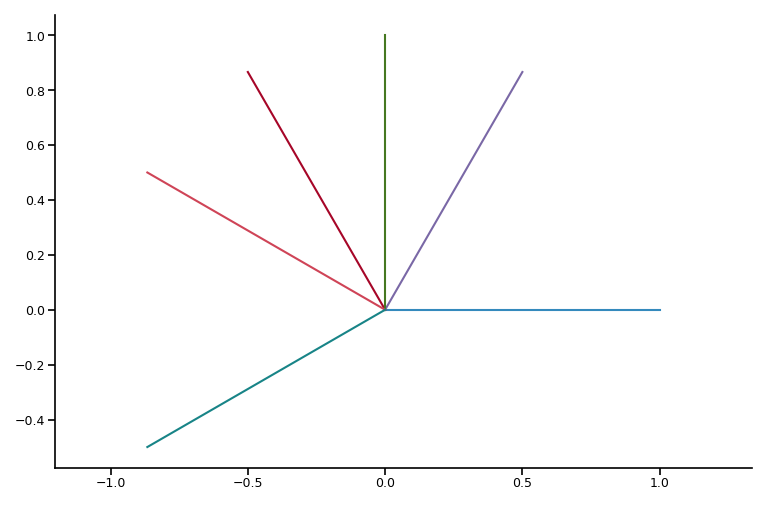

In [16]:
e1 = np.array([1,0])
basis_vectors = [rotation_matrix(60*i) @ e1 for i in range(3)]
basis_vectors = np.array(basis_vectors + [rotation_matrix(90) @ k for k in basis_vectors])

# plot basis vectors
for i in range(6):
    plt.plot([0, basis_vectors[i,0]], [0, basis_vectors[i,1]])
plt.axis('equal')


In [17]:
nstats = 30
load_stats = False
e1 = np.array([0,1])
basis_vectors = [rotation_matrix(60*i) @ e1 for i in range(3)]
basis_vectors = np.array(basis_vectors + [rotation_matrix(90) @ k for k in basis_vectors])

if load_stats:
    with open(experiment.paths['experiment'] / "band_pruning.pkl", "rb") as f:
        pruning_errors = pickle.load(f)
else:
    pruning_errors = []
    for basis_vector in basis_vectors:
        dataset = Dataset(agents = agents, pc_ensembles = pc_ensembles, num_samples = nstats, seq_len=seq_len, basis_vector=basis_vector)#, **params)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=params['batch_size'], sampler = datasampler, num_workers=num_workers)
        pruning_error = prune_model(model, random_model, dataloader, *band_cells, trajectory_slice=slice(19,20), nsamples=nstats, ncells2prune=100)
        pruning_errors.append(pruning_error)
    pruning_errors = np.array(pruning_errors)
    # save pruning errors statistics - since it takes so long to compute it can be loaded instead
    with open(experiment.paths['experiment'] / "band_pruning.pkl", "wb") as f:
        pickle.dump(pruning_errors, f)

Processing batches:  20%|██        | 6/30 [00:21<01:18,  3.26s/it]

In [ ]:
panesize = set_size(width=345, mode='tall')
panesize

figsize=(panesize[0],panesize[1]*2/6)
figsize=np.array(figsize)

In [ ]:
pruning_errors.shape

In [ ]:
median_error = np.median(pruning_errors, axis=1)
for i in range(6):
    fig,ax = plt.subplots()
    for j, basis_vector in enumerate(basis_vectors):
        ax.arrow(0, 0, *(median_error[j,i]*basis_vector), head_width=0.05, head_length=0.1, fc='k', ec='k')

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
x_ticks = np.arange(0,nstats,1)
labels = ['Full Model'] + ['Random Pruning'] + ['Full Untrained Model'] + ['Band Cells 1'] + ['Band Cells 2'] + ['Band Cells 3'] 
ls = ['-']*len(labels)
ls[-4] = '-.'
ls[-2] = '-.'

mean_error = np.mean(pruning_errors,axis=0).T
std_error = np.std(pruning_errors,axis=0).T
median_error = np.median(pruning_errors,axis=0).T
mad_error = mad(pruning_errors,axis=0).T
for i in range(len(labels)): # set order to change color according to color-cycler
    #ax.plot(x_ticks, mean_error[i], label=labels[i])#np.mean(pruning_i,axis=0))
    #ax.fill_between(x_ticks, mean_error[i] + std_error[i], mean_error[i] - std_error[i], alpha=0.1)
    ax.plot(x_ticks, median_error[i], label=labels[i], ls=ls[i])#np.mean(pruning_i,axis=0))
    ax.fill_between(x_ticks, median_error[i] + mad_error[i], median_error[i] - mad_error[i], alpha=0.1)

#ax.scatter(x_ticks[None]*np.ones((30,1)), pruning_errors[:,1], s=5, alpha=0.5, c=ax.lines[-1].get_color())


ax.legend()
ax.set_xlabel('Time steps')
ax.set_ylabel('Decoding Error')
ax.axvline(20, c='k', ls='--')

fig.savefig(experiment.paths['experiment'] / f'plots/time_pruning')
